In [45]:
import pandas as pd
import requests
import json
from base64 import b64encode, b64decode

import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)


# Função para buscar o tradingName pelo ticker
def get_trading_name(ticker):
    params = {"language": "pt-br", "pageNumber": 1, "pageSize": 20, "company": ticker}
    params = bytes(str(params), encoding="ascii")
    string = b64encode(params).decode()
    r = requests.get(
        'https://sistemaswebb3-listados.b3.com.br/listedCompaniesProxy/CompanyCall/GetInitialCompanies/' +
        string,
        verify=False
    )
    for i in r.json()['results']:
        if i['issuingCompany'].lower() == ticker.lower():
            return i['tradingName'].replace('/', '').replace('.', '')
    raise ValueError('Empresa não encontrada')

# Função para obter os proventos
def proventos(ticker):
    tradingName = get_trading_name(ticker)
    results = []
    n = 1
    while True:
        params = {"language": "pt-br", "pageNumber": n, "pageSize": 100, "tradingName": tradingName}
        params = bytes(str(params), encoding="ascii")
        string = b64encode(params).decode()
        r = requests.get(
            'https://sistemaswebb3-listados.b3.com.br/listedCompaniesProxy/CompanyCall/GetListedCashDividends/' +
            string,
            verify=False
        )
        if not r.json()['results']:
            break
        results += r.json()['results']
        n += 1
    return results


In [46]:
get_trading_name('bbse')

'BBSEGURIDADE'

In [47]:
proventos_data = proventos('bbse')

In [48]:
data = pd.DataFrame(proventos_data)
data.head()

,typeStock,dateApproval,valueCash,ratio,corporateAction,lastDatePriorEx,dateClosingPricePriorExDate,closingPricePriorExDate,quotedPerShares,corporateActionPrice,lastDateTimePriorEx
0,ON,27/06/2025,"1,9420951555",1,DIVIDENDO,14/08/2025,14/08/2025,"35,32",1,"5,498571",2025-08-14T00:00:00
1,ON,20/12/2024,"2,27232921286",1,DIVIDENDO,20/02/2025,20/02/2025,"39,86",1,"5,700776",2025-02-20T00:00:00
2,ON,20/12/2024,"0,04783204654",1,RENDIMENTO,20/02/2025,20/02/2025,"39,86",1,"0,120000",2025-02-20T00:00:00
3,ON,21/06/2024,"1,39090855697",1,DIVIDENDO,16/08/2024,16/08/2024,"37,29",1,"3,729977",2024-08-16T00:00:00
4,ON,15/12/2023,"1,24187556069",1,DIVIDENDO,08/02/2024,08/02/2024,"34,50",1,"3,599639",2024-02-08T00:00:00


In [54]:
data.tail()

,typeStock,dateApproval,valueCash,ratio,corporateAction,lastDatePriorEx,dateClosingPricePriorExDate,closingPricePriorExDate,quotedPerShares,corporateActionPrice,lastDateTimePriorEx,year
41,ON,08/08/2014,0.010896,1,RENDIMENTO,18/08/2014,18/08/2014,"34,94",1,"0,031185",2014-08-18T00:00:00,2014
42,ON,11/02/2014,0.580577,1,DIVIDENDO,14/02/2014,14/02/2014,"24,34",1,"2,385280",2014-02-14T00:00:00,2014
43,ON,11/02/2014,0.009073,1,RENDIMENTO,14/02/2014,14/02/2014,"24,34",1,"0,037276",2014-02-14T00:00:00,2014
44,ON,09/08/2013,0.408924,1,DIVIDENDO,19/08/2013,19/08/2013,"18,68",1,"2,189101",2013-08-19T00:00:00,2013
45,ON,09/08/2013,0.005864,1,RENDIMENTO,19/08/2013,19/08/2013,"18,68",1,"0,031391",2013-08-19T00:00:00,2013


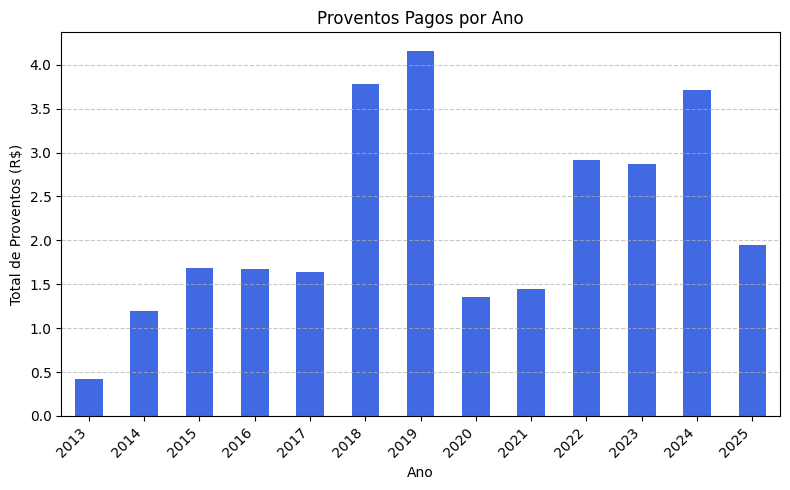

In [49]:
import matplotlib.pyplot as plt

# Converte 'valueCash' de string com vírgula para float
data["valueCash"] = data["valueCash"].str.replace(",", ".").astype(float)
# Extrai o ano da data de aprovação
data["year"] = pd.to_datetime(data["dateApproval"], dayfirst=True).dt.year
# Agrupa por ano e soma os proventos
proventos_anuais = data.groupby("year")["valueCash"].sum()


# Plota o gráfico
plt.figure(figsize=(8, 5))
proventos_anuais.plot(kind="bar", color="royalblue")
plt.title("Proventos Pagos por Ano")
plt.xlabel("Ano")
plt.ylabel("Total de Proventos (R$)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [53]:

# proventos via Fundamentus

from io import StringIO

url1 = f'https://www.fundamentus.com.br/proventos.php?papel={codigo}&tipo=2'
header = { 
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36", "X-Requested-With": "XMLHttpRequest"
    }
r1 = requests.get(url1, headers=header)
dy = pd.read_html(StringIO(r1.text), decimal=',', thousands='.')[0]
dy['Data'] = pd.to_datetime(dy['Data'] , dayfirst=True)
dy.set_index('Data',inplace =True )
dy['Valor/acao'] = dy['Valor']/dy['Por quantas ações']

fig = go.Figure(
    [ go.Bar(x=dy.index.year , y = dy['Valor'],name='Valor'),
     go.Bar(x=dy.index.year , y = dy['Valor/acao'],name='Valor/ação')],
    layout=dict(title='Dividendos ',height=500, width=700 ))
fig.show()

In [52]:
import plotly.graph_objects as go

# Gráfico com Plotly
fig = go.Figure(
    data=[
        go.Bar(
            x=data["year"],
            y=data["valueCash"],
            marker_color="royalblue",
            text=data["valueCash"].round(3),
            textposition="outside"
        )
    ]
)

fig.update_layout(
    title="Proventos Pagos por Ano",
    xaxis_title="Ano",
    yaxis_title="Total de Proventos (R$)",
    xaxis_tickangle=90,
    template="plotly_white",
    height=400
)

fig.show()


Fonte: https://fabiomt.medium.com/como-obter-o-hist%C3%B3rico-de-dividendos-e-outros-proventos-com-python-direto-do-site-da-b3-90a507623418


testes:

In [ ]:
s = 'eyJsYW5ndWFnZSI6InB0LWJyIiwicGFnZU51bWJlciI6MSwicGFnZVNpemUiOjIwLCJ0cmFkaW5nTmFtZSI6IkJSQVNJTCJ9'
url = 'https://sistemaswebb3-listados.b3.com.br/listedCompaniesProxy/CompanyCall/GetListedCashDividends/'
r=requests.get(url + s)
r.json()

{'page': {'pageNumber': 1,
  'pageSize': 20,
  'totalRecords': 268,
  'totalPages': 14},
 'results': [{'typeStock': 'ON',
   'dateApproval': '10/11/2025',
   'valueCash': '0,04583263233',
   'ratio': '1',
   'corporateAction': 'JRS CAP PROPRIO',
   'lastDatePriorEx': '02/12/2025',
   'dateClosingPricePriorExDate': '02/12/2025',
   'closingPricePriorExDate': '22,56',
   'quotedPerShares': '1',
   'corporateActionPrice': '0,203159',
   'lastDateTimePriorEx': '2025-12-02T00:00:00'},
  {'typeStock': 'ON',
   'dateApproval': '10/11/2025',
   'valueCash': '0,07192713139',
   'ratio': '1',
   'corporateAction': 'JRS CAP PROPRIO',
   'lastDatePriorEx': '01/12/2025',
   'dateClosingPricePriorExDate': '01/12/2025',
   'closingPricePriorExDate': '22,26',
   'quotedPerShares': '1',
   'corporateActionPrice': '0,323123',
   'lastDateTimePriorEx': '2025-12-01T00:00:00'},
  {'typeStock': 'ON',
   'dateApproval': '14/05/2025',
   'valueCash': '0,33425840109',
   'ratio': '1',
   'corporateAction': 'JR

In [ ]:
padrao = b64decode(s)
padrao

b'{"language":"pt-br","pageNumber":1,"pageSize":20,"tradingName":"BRASIL"}'

In [ ]:
# max item/pagina = 120
s = b64encode(b'{"language":"pt-br","pageNumber":1,"pageSize":120,"tradingName":"BRASIL"}').decode()
s

'eyJsYW5ndWFnZSI6InB0LWJyIiwicGFnZU51bWJlciI6MSwicGFnZVNpemUiOjEyMCwidHJhZGluZ05hbWUiOiJCUkFTSUwifQ=='

In [ ]:
r=requests.get(url + s)
print(r.json()['results'][-1])
r.json()

{'typeStock': 'ON', 'dateApproval': '11/08/2015', 'valueCash': '0,00032874943', 'ratio': '1', 'corporateAction': 'RENDIMENTO', 'lastDatePriorEx': '21/08/2015', 'dateClosingPricePriorExDate': '21/08/2015', 'closingPricePriorExDate': '18,56', 'quotedPerShares': '1', 'corporateActionPrice': '0,001771', 'lastDateTimePriorEx': '2015-08-21T00:00:00'}


{'page': {'pageNumber': 1,
  'pageSize': 120,
  'totalRecords': 268,
  'totalPages': 3},
 'results': [{'typeStock': 'ON',
   'dateApproval': '10/11/2025',
   'valueCash': '0,04583263233',
   'ratio': '1',
   'corporateAction': 'JRS CAP PROPRIO',
   'lastDatePriorEx': '02/12/2025',
   'dateClosingPricePriorExDate': '02/12/2025',
   'closingPricePriorExDate': '22,56',
   'quotedPerShares': '1',
   'corporateActionPrice': '0,203159',
   'lastDateTimePriorEx': '2025-12-02T00:00:00'},
  {'typeStock': 'ON',
   'dateApproval': '10/11/2025',
   'valueCash': '0,07192713139',
   'ratio': '1',
   'corporateAction': 'JRS CAP PROPRIO',
   'lastDatePriorEx': '01/12/2025',
   'dateClosingPricePriorExDate': '01/12/2025',
   'closingPricePriorExDate': '22,26',
   'quotedPerShares': '1',
   'corporateActionPrice': '0,323123',
   'lastDateTimePriorEx': '2025-12-01T00:00:00'},
  {'typeStock': 'ON',
   'dateApproval': '14/05/2025',
   'valueCash': '0,33425840109',
   'ratio': '1',
   'corporateAction': 'JR